# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.non_parametric_tests import *
from utils.PerformanceProfiles  import *

# Import data

In [3]:
from os import listdir
from os.path import isfile, join

path = 'Predictions/'
Files = [f for f in listdir( path ) if isfile(join(path, f))]

print('[INFO] Number of methods: ', len(Files) )

[INFO] Number of methods:  3


In [4]:
df = None
for file in Files:
    # Get method
    Method = file.split('.')[0]    
    # Load data
    temp = pd.read_csv(path + file)
    # Calculate Absolute Errors
    temp[ Method ] = (temp.iloc[:,1] - temp.iloc[:,2]).abs().round(4)
    # Include date & Absolute Errors
    temp = temp[ ['Date', Method] ]
    temp.set_index('Date', inplace=True)
    
    if (df is None):
        df = temp
    else:
        df = pd.concat([df, temp], axis=1)
        
df.head( 5 )

,Method 1,Method 2,Method 3
Date,,,
2022-02-12 01:45:00,0.0085,0.0885,0.0636
2022-02-12 01:50:00,0.0944,0.0806,0.0162
2022-02-12 01:55:00,0.1258,0.0836,0.1239
2022-02-12 02:00:00,0.2315,0.0311,0.0453
2022-02-12 02:05:00,0.3250,0.0715,0.1284


# Statistical analysis

- Derrac, J., García, S., Molina, D., & Herrera, F. (2011). A practical tutorial on the use of nonparametric statistical tests as a methodology for comparing evolutionary and swarm intelligence algorithms. Swarm and Evolutionary Computation, 1(1), 3-18.

- García, S., Fernández, A., Luengo, J., & Herrera, F. (2010). Advanced nonparametric tests for multiple comparisons in the design of experiments in computational intelligence and data mining: Experimental analysis of power. Information sciences, 180(10), 2044-2064.

## Friedman Aligned Ranking (FAR)

In [5]:
T, p_value, rankings_avg, rankings_cmp = friedman_aligned_ranks_test( df )


# Summary
#
print('\n')
print('[INFO] H0: {All methods exhibited similar results with no statistical differences}')
print('[INFO] FAR: %.3f (p-value: %.5f)' % (T, p_value))
if (p_value < 0.05):
    print('\t> H0 is rejected')
else:
    print('\t> H0 is failed to be rejected')

[INFO] Number of methods:   3
[INFO] Number of problems:  1014


[INFO] H0: {All methods exhibited similar results with no statistical differences}
[INFO] FAR: 11.825 (p-value: 0.00271)
	> H0 is rejected


### FAR ranking

In [6]:
Ranking = pd.DataFrame( [] )
Ranking['Methods'] = df.columns
Ranking['FAR']     = rankings_avg

Ranking.sort_values(by = 'FAR')

,Methods,FAR
2,Method 3,1460.199704
1,Method 2,1491.409763
0,Method 1,1612.890533


## Finner post-hoc test

In [7]:
### Create dictionary with rankings

d = {}
for i, feature in enumerate(df.columns):
    d[ feature ] = rankings_cmp[i] 

### Multiple comparisons ($1 \times N$)

**Finner post-hoc test**

In [8]:
comparisons, z_values, p_values, adj_p_values = finner_test( d )

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner

[INFO] Control method:  Method 3


,Comparisons,APV,Null hypothesis
0,Method 3 vs Method 1,0.000181,Rejected
1,Method 3 vs Method 2,0.423638,Failed to reject


### Multiple comparisons ($N \times N$)

**Finner-multitest post-hoc test**

In [9]:
comparisons, z_values, p_values, adj_p_values = finner_multitest(d)

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner

,Comparisons,APV,Null hypothesis
0,Method 1 vs Method 3,0.000272,Rejected
1,Method 1 vs Method 2,0.002764,Rejected
2,Method 2 vs Method 3,0.423638,Failed to reject


# Performance profiles

- Dolan, E. D., & Moré, J. J. (2002). Benchmarking optimization software with performance profiles. Mathematical programming, 91(2), 201-213.
ISO 690	


            Method 1 solved 36.39% of cases with the best (least) score
            Method 2 solved 28.80% of cases with the best (least) score
            Method 3 solved 35.01% of cases with the best (least) score


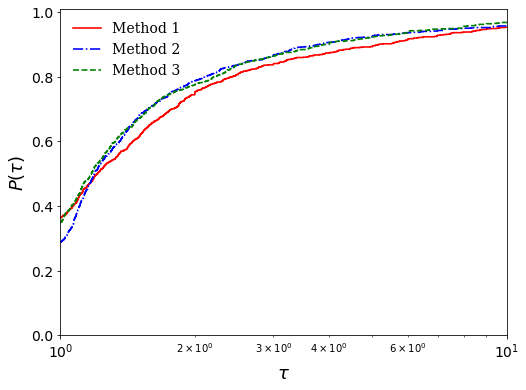

In [10]:
perfprof(df, 
         linespecs = ['r-', 'b-.', 'g--'], 
         digit = 3,
         legendnames = df.columns,
         thmax = 10, figsize = (8, 6))

plt.xscale('log')